# Testing emission models

This jupyter notebook is to test different emission models, including a Gaussian mixture, a directional model (VMF), and our novely desinged Gaussian Mixture with exponential signal strength. The main porpuse of this short example is trying to show the three models are correctly fitted via an EM procedure.

<br>
<br>

## General EM process for emission models fitting

Given the Markov property, the emission models specify the log probability of the observed data as a function of $\mathbf{u}$.  

$$
\log p(\mathbf{Y}|\mathbf{U};\theta_E)=\sum_i \log p(\mathbf{y}_i|\mathbf{u}_i;\theta_E)
$$

Furthermore, assuming that $\mathbf{u}_i$ is a one-hot encoded indicator variable (parcellation model), we can write the expected emission log-likelihood as: 
$$
\mathcal{L}_E=\langle \log p(\mathbf{Y}|\mathbf{U};\theta_E)\rangle =\sum_i \sum_k \langle u_i^{(k)}\log p(\mathbf{y}_i|u_i=k;\theta_E) \rangle
$$
In the E-step the emission model simply passes $p(\mathbf{y}_i|\mathbf{u}_i;\theta_E)$ as a message to the arrangement model. In the M-step, $q(\mathbf{u}_i) = \langle \mathbf{u}_i \rangle$ is passed back, and the emission model optimizes the above quantity in respect to $\theta_E $.

<br>
<br>

## Emission models description

### 1. Gaussian Mixture model (GMM)

Under the Gaussian mixture model, we model the emissions as a Gaussian with a parcel-specific mean ($\mathbf{v}_k$), and with equal isotropic variance across parcels and observations:

$$
p(\mathbf{y_i}|u^{(k)};\theta_E) = \frac{1}{(2\pi)^{N/2}(\sigma^{2})^{N/2}}\rm{exp}\{-\frac{1}{2\sigma^{2}}(y_{i}-\mathbf{v}_k)^T(y_{i}-\mathbf{v}_k)\}
$$

Then we can calculate the expected emission log likelihood, and update the parameters $\theta_E = \{\mathbf{v}_1,...,\mathbf{v}_K,\sigma^2\}$ in the $M$ step. 

### 2. von-Mises Fisher Mixture model (VMF)
For a $N$-dimensional data $\mathbf{y} (||\mathbf{y}||_2=1) $ the probability density function of von Mises-Fisher distribution is defined as following,

$$
V_N(\mathbf{y}|\mathbf{v}_k,\kappa) = C_N(\kappa)exp(\kappa\mathbf{v}_k^{T}\mathbf{y})
$$

where $\mathbf{v}_k$ denotes the mean direction (unit vectors for each parcels), $\kappa$ indicates the concentration parameter ($\kappa\geqslant0$), which is joint over all parcels. $C_N(\kappa) = \frac{\kappa^{N/2-1}}{(2\pi)^{N/2}I_{N/2-1}(\kappa)}$ is the normalization constant where $I_r(.)$ refers to the modified Bessel function of the $r$ order. 

Now, we update the parameters $\theta$ of the von-Mises mixture in the $M$ step by maximizing $\mathcal{L}_E$  in respect to the parameters in von-Mises mixture $\theta_{k}=\{\mathbf{v}_{k},\kappa\}$. (Note: the updates only consider a single subject).

### 3. Gaussian Mixture model with exponential signal strength (GMM_exp)

One issue of the functional activation is that the signal-to-noise ratio (SNR) can be quite different across different participants, and voxels, with many voxels having relatively low SNR. We model this signal to noise for each brain location (and subject) as $s_i \sim Exp(\theta_{\beta s})$. Therefore the probability model for exponential (later on replaced by gamma) is defined as:

$$
p(s_i|\theta) = \beta e^{-\beta s_i}
$$

Overall, the expected signal at each brain location is then $\rm{E}(\mathbf{y}_i)=\mathbf{u}_i^T \mathbf{V}s_i$. Finally, relative to the signal, we assume that the noise is distributed i.i.d Gaussian with $\boldsymbol{\epsilon}_i \sim Normal(0,\mathbf{I}_K\theta_{\sigma s})$.

Here, the proposal distribution $q(u_{i}^{(k)},s_{i}|\mathbf{y}_{i})$ is now a multivariate distribution across $u_i$ and $s_i$. Thus, the *expected emission log likelihood* $\mathcal{L}_E(q, \theta)$ is defined as:

$$
\mathcal{L}_E = \langle\sum_i\log p(\mathbf{y}_i, s_i|u_i; \theta_E)\rangle_{q}
$$

We then update the parameters $\theta$ of the Gaussians/Exp mixture in the $M$ step. The parameters of the gaussian mixture model are $\theta_{E} = \{\mathbf{v}_{1},...,\sigma^{2},\beta\}$ . 

<br>
<br>

## Testing the data generation process
First, we will test and visualize data generated from each of these emission models. We will do this in 2-d to be able to visualize the results (could repeat in 3d). 


In [2]:
%load_ext autoreload
%autoreload 2 
import os
import sys 
sys.path.append(os.path.abspath('..'))
import numpy as np
import matplotlib.pyplot as plt
import torch as pt
import seaborn as sb

import arrangements as ar
import emissions as em
import full_model as fm



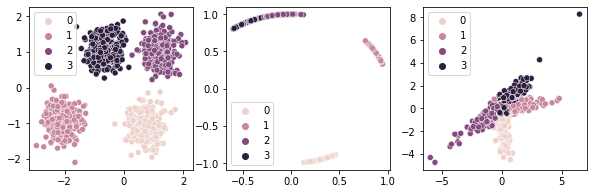

In [6]:
K=4
P=1000
N=2
num_sub=1
arrange = ar.ArrangeIndependent(K=K, P=P, spatial_specific=False, remove_redundancy=False)


emissionGMM = em.MixGaussian(K=K, N=N, P=P)
emissionGMM.sigma2 = pt.tensor(0.1)
emissionVMF = em.MixVMF(K=K,N=N,P=P)
emissionVMF.kappa = pt.tensor(200)
emissionGME = em.MixGaussianExp(K=K,N=N,P=P)
emissionGME.sigma2 = 0.1

# Step 1: Generate data by sampling from the above model
U = arrange.sample(num_subj=1)
Y=[]
Y.append(emissionGMM.sample(U))
Y.append(emissionVMF.sample(U))
Y.append(emissionGME.sample(U))

plt.figure(figsize=(10,3))
for i in range(3): 
    plt.subplot(1,3,i+1)
    sb.scatterplot(x=Y[i][0,0,:],y=Y[i][0,1,:],hue=U[0]) 


## Fitting model using generated data

Here we will fit the three emission model by given the true generated data from each model. Since the main propose is to test the emission models standalone, we freeze the arrangement model to use `Independent arrangement model` for all model fitting. It means each brain location has no spatial relations with nearby or all other location. 


### 1. Fitting GMM

The testing process for each of the emission model is quiet similar as shown below. First, we initialize the true arrangement model and emission model with the true parameters. Secondly, we generate the true data from the true model, then compute the true emission log-likelihood for later use. Thirdly, we create another arrangement/emission model for data fitting. Lastly, we run EM algorithm for optimizing the model parameters.

In [4]:
# Some basic experimental settings throught the three emission models
K=5
P=1000
N=40
num_sub=10
max_iter=100



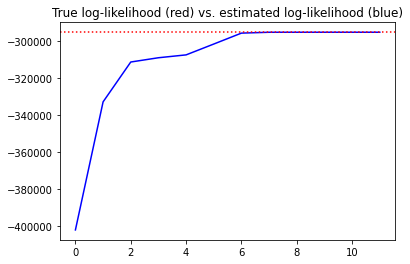

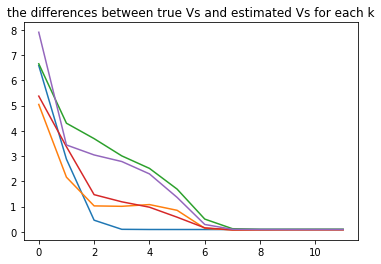

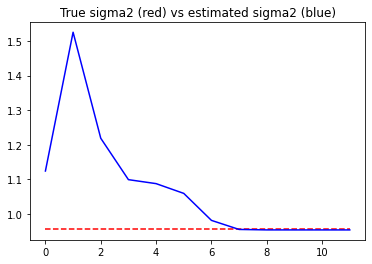

Done simulation GMM.


In [4]:
from test_emissions import _simulate_full_GMM

_simulate_full_GMM(K=5, P=1000, N=20, num_sub=10, max_iter=100)

This is the curve of emission log-likelihood by iterations.

Here, we also plot the difference (distance) between the true Vs and the estimated Vs in the upper figure, and plot the true sigma vs. the estimated signma square at the bottom figure.

### 2. Fitting VMF

The process for the rest two emission models are basically the same. To save ink, I just call pre-defined testing function to run the data fitting.

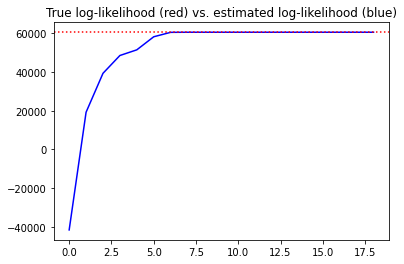

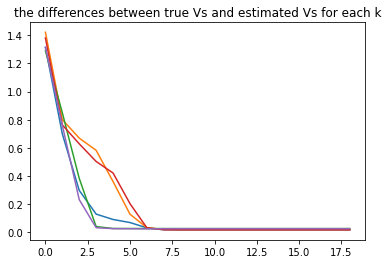

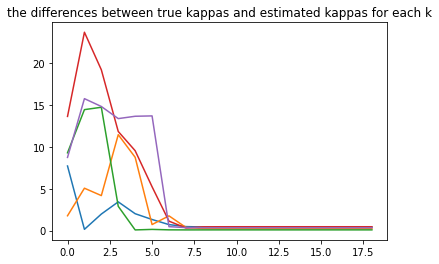

Done simulation VMF.


In [7]:
from test_emissions import _simulate_full_VMF

_simulate_full_VMF(K=5, P=1000, N=20, num_sub=10, max_iter=100, uniform_kappa=False)

### 3. Fitting GMM_exp



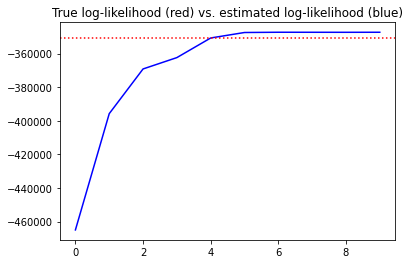

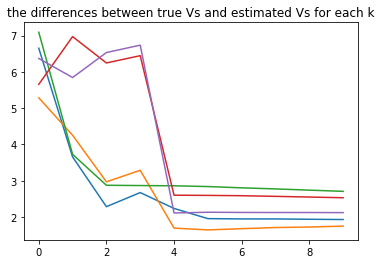

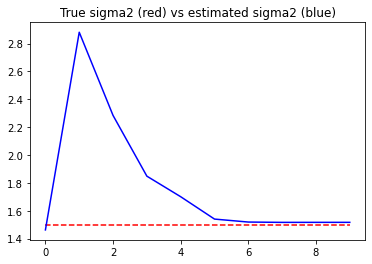

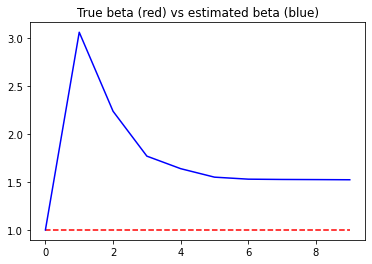

Done simulation GME.


In [5]:
from test_emissions import _simulate_full_GME
_simulate_full_GME(K=5, P=1000, N=20, num_sub=10, max_iter=10)

## Evaluating emission models using the same dataset

Here we will fit the three emission model by given the true generated data from each model. Since the main propose is to test the emission models standalone, we freeze the arrangement model to use `Independent arrangement model` for all model fitting. It means each brain location has no spatial relations with nearby or all other location. 

### 1. Using data generated from GMM

In the first quantitative comparison, we fit the three emission models on the data generated from Gaussian Mixture model. Then we compute the adjusted mean squared error for all models to compare.

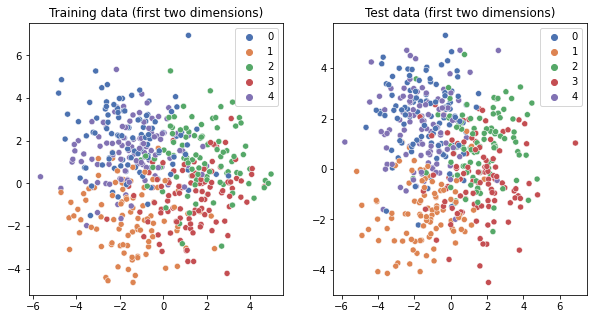

In [61]:
from evaluation import *

# Evaluate emission models
num_sub = 10
P = 500
K = 5
N = 20

# Step 1. generate the training dataset from VMF model given a signal length
signal = pt.distributions.exponential.Exponential(1.0).sample((num_sub, P))
Y_train, Y_test, signal_true, U, MT = generate_data(0, k=K, dim=N, p=P, signal_strength=signal, sigma2=2, do_plot=True)
# standardise Y to unit length for VMF
Y_train_vmf = Y_train / pt.sqrt(pt.sum(Y_train ** 2, dim=1)).unsqueeze(1).repeat(1, Y_train.shape[1], 1)
Y_test_vmf = Y_test / pt.sqrt(pt.sum(Y_test ** 2, dim=1)).unsqueeze(1).repeat(1, Y_test.shape[1], 1)

In [62]:
# Step 2a. Fit the competing emission model using the training data
emissionM1 = MixGaussian(K=K, N=N, P=P)
emissionM2 = MixGaussianExp(K=K, N=N, P=P)
emissionM3 = MixVMF(K=K, N=N, P=P, uniform_kappa=False)
M1 = FullModel(MT.arrange, emissionM1)
M2 = FullModel(MT.arrange, emissionM2)
M3 = FullModel(MT.arrange, emissionM3)
M1, _, _, Uhat1_train = M1.fit_em(Y=Y_train, iter=100, tol=0.00001, fit_arrangement=False)
M2, _, _, Uhat2_train = M2.fit_em(Y=Y_train, iter=100, tol=0.00001, fit_arrangement=False)
M3, _, _, Uhat3_train = M3.fit_em(Y=Y_train_vmf, iter=100, tol=0.00001, fit_arrangement=False)

# Step 2b. Predict test data using the trained model
Uhat1_test, _ = M1.Estep(Y=Y_test)
Uhat2_test, _ = M2.Estep(Y=Y_test, signal=signal_true)
Uhat3_test, _ = M3.Estep(Y=Y_test_vmf)

Text(0.5, 0.98, 'Fitting results on training data')

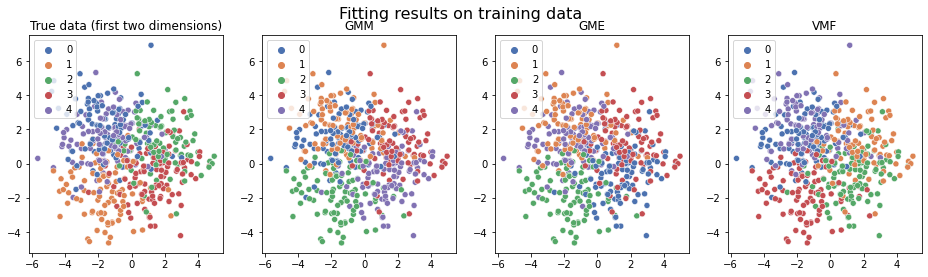

In [63]:
import matplotlib.pyplot as plt
import seaborn as sb

fig1 = plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=U[0], palette="deep")
plt.title('True data (first two dimensions)')
plt.subplot(1, 4, 2)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=pt.argmax(Uhat1_train, dim=1)[0], palette="deep")
plt.title('GMM')
plt.subplot(1, 4, 3)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=pt.argmax(Uhat2_train, dim=1)[0], palette="deep")
plt.title('GME')
plt.subplot(1, 4, 4)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=pt.argmax(Uhat3_train, dim=1)[0], palette="deep")
plt.title('VMF')
fig1.suptitle('Fitting results on training data', fontsize=16)

Text(0.5, 0.98, 'Fitting results on test data')

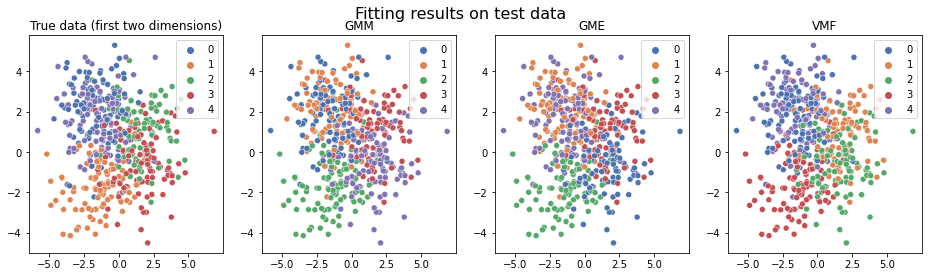

In [64]:
fig2 = plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=U[0], palette="deep")
plt.title('True data (first two dimensions)')
plt.subplot(1, 4, 2)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=pt.argmax(Uhat1_test, dim=1)[0], palette="deep")
plt.title('GMM')
plt.subplot(1, 4, 3)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=pt.argmax(Uhat2_test, dim=1)[0], palette="deep")
plt.title('GME')
plt.subplot(1, 4, 4)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=pt.argmax(Uhat3_test, dim=1)[0], palette="deep")
plt.title('VMF')
fig2.suptitle('Fitting results on test data', fontsize=16)

### Testing prediction error, cosine error, and adjusted SSE on test data

In [65]:
# Step 3a. evaluate the fitted emission (actually the full model with
# freezing the arrangement model) models by a given criterion.
criterion = ['u_prederr', 'coserr', 'adjustSSE']
res_gmm = pt.empty(len(criterion), 3)
for c in range(len(criterion)):
    acc1 = evaluate_completion_emission(M1, Y_test, U_true=U, crit=criterion[c])
    acc2 = evaluate_completion_emission(M2, Y_test, U_true=U, crit=criterion[c])
    acc3 = evaluate_completion_emission(M3, Y_test, U_true=U, U_predict=Uhat3_test, crit=criterion[c])
    res_gmm[c, 0] = acc1
    res_gmm[c, 1] = acc2
    res_gmm[c, 2] = acc3
    print(acc1, acc2, acc3)

tensor(0.0462) tensor(0.0520) tensor(0.0482)
tensor(0.4296) tensor(0.4289) tensor(0.4295)
tensor(39.4669) tensor(51.2981) tensor(6.3962)


### 2. Using data generated from GME (Repeat above)

Secondly, we fit the three emission models on the data generated from Gaussian Mixture model with exponential signal strength. Then we compute the adjusted mean squared error for all models to compare. Note, we here drew a signal strength from exponential distribution and applied to the mean of Gaussian components. For fitting VMF model, we have to normalize the training data to unit norm.

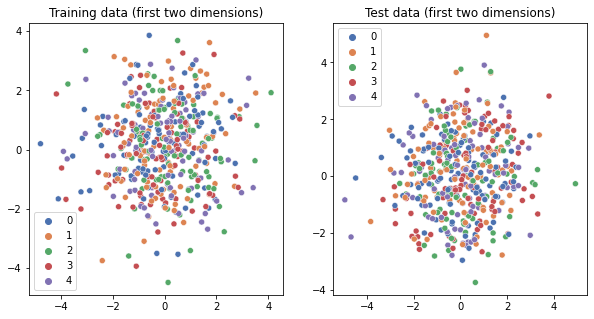

In [66]:
# Step 1. generate the training dataset from GME model given a signal length
Y_train, Y_test, signal_true, U, MT = generate_data(1, k=K, dim=N, p=P, signal_strength=signal, sigma2=2, do_plot=True)
# standardise Y to unit length for VMF
Y_train_vmf = Y_train / pt.sqrt(pt.sum(Y_train ** 2, dim=1)).unsqueeze(1).repeat(1, Y_train.shape[1], 1)
Y_test_vmf = Y_test / pt.sqrt(pt.sum(Y_test ** 2, dim=1)).unsqueeze(1).repeat(1, Y_test.shape[1], 1)

In [67]:
# Step 2a. Fit the competing emission model using the training data
emissionM1 = MixGaussian(K=K, N=N, P=P)
emissionM2 = MixGaussianExp(K=K, N=N, P=P)
emissionM3 = MixVMF(K=K, N=N, P=P, uniform_kappa=False)
M1 = FullModel(MT.arrange, emissionM1)
M2 = FullModel(MT.arrange, emissionM2)
M3 = FullModel(MT.arrange, emissionM3)
M1, _, _, Uhat1_train = M1.fit_em(Y=Y_train, iter=100, tol=0.00001, fit_arrangement=False)
M2, _, _, Uhat2_train = M2.fit_em(Y=Y_train, iter=100, tol=0.00001, fit_arrangement=False)
M3, _, _, Uhat3_train = M3.fit_em(Y=Y_train_vmf, iter=100, tol=0.00001, fit_arrangement=False)

# Step 2b. Predict test data using the trained model
Uhat1_test, _ = M1.Estep(Y=Y_test)
Uhat2_test, _ = M2.Estep(Y=Y_test, signal=signal_true)
Uhat3_test, _ = M3.Estep(Y=Y_test_vmf)

Text(0.5, 0.98, 'Fitting results on training data')

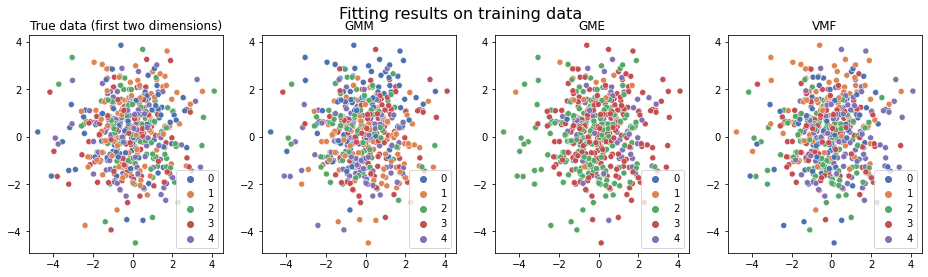

In [68]:
import matplotlib.pyplot as plt
import seaborn as sb

fig1 = plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=U[0], palette="deep")
plt.title('True data (first two dimensions)')
plt.subplot(1, 4, 2)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=pt.argmax(Uhat1_train, dim=1)[0], palette="deep")
plt.title('GMM')
plt.subplot(1, 4, 3)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=pt.argmax(Uhat2_train, dim=1)[0], palette="deep")
plt.title('GME')
plt.subplot(1, 4, 4)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=pt.argmax(Uhat3_train, dim=1)[0], palette="deep")
plt.title('VMF')
fig1.suptitle('Fitting results on training data', fontsize=16)

Text(0.5, 0.98, 'Fitting results on test data')

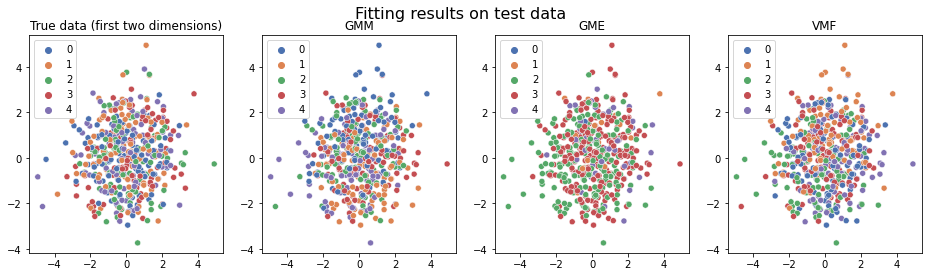

In [69]:
fig2 = plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=U[0], palette="deep")
plt.title('True data (first two dimensions)')
plt.subplot(1, 4, 2)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=pt.argmax(Uhat1_test, dim=1)[0], palette="deep")
plt.title('GMM')
plt.subplot(1, 4, 3)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=pt.argmax(Uhat2_test, dim=1)[0], palette="deep")
plt.title('GME')
plt.subplot(1, 4, 4)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=pt.argmax(Uhat3_test, dim=1)[0], palette="deep")
plt.title('VMF')
fig2.suptitle('Fitting results on test data', fontsize=16)

### Testing prediction error, cosine error, and adjusted SSE on test data

In [70]:
# Step 3a. evaluate the fitted emission (actually the full model with
# freezing the arrangement model) models by a given criterion.
criterion = ['u_prederr', 'coserr', 'adjustSSE']
res_gme = pt.empty(len(criterion), 3)
for c in range(len(criterion)):
    acc1 = evaluate_completion_emission(M1, Y_test, U_true=U, crit=criterion[c])
    acc2 = evaluate_completion_emission(M2, Y_test, U_true=U, crit=criterion[c])
    acc3 = evaluate_completion_emission(M3, Y_test, U_true=U, U_predict=Uhat3_test, crit=criterion[c])
    res_gme[c, 0] = acc1
    res_gme[c, 1] = acc2
    res_gme[c, 2] = acc3
    print(acc1, acc2, acc3)

tensor(0.6904) tensor(0.7048) tensor(0.6518)
tensor(0.6866) tensor(0.8695) tensor(0.6842)
tensor(38.0851) tensor(41.1935) tensor(8.6885)


### 3. Using data generated from VMF (Repeat above)

Lastly, we fit the three emission models on the data generated from von-Mises Fisher Mixture model. Then we compute the adjusted mean squared error for all models to compare. Note, we here drew a signal strength form exponential distribution and applied on the generated VMF data, because the generated data is on the spherical surface and we need give each brain location a signal strength to mimic the real data, hence fit other models.

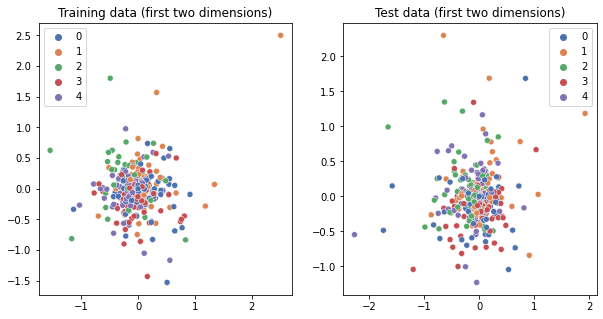

In [71]:
# Step 1. generate the training dataset from VMF model given a signal length
signal = pt.distributions.exponential.Exponential(1.0).sample((num_sub, P))
Y_train, Y_test, signal_true, U, MT = generate_data(3, k=K, dim=N, p=P, signal_strength=signal, sigma2=2, do_plot=True)
# standardise Y to unit length for VMF
Y_train_vmf = Y_train / pt.sqrt(pt.sum(Y_train ** 2, dim=1)).unsqueeze(1).repeat(1, Y_train.shape[1], 1)
Y_test_vmf = Y_test / pt.sqrt(pt.sum(Y_test ** 2, dim=1)).unsqueeze(1).repeat(1, Y_test.shape[1], 1)

In [72]:
# Step 2a. Fit the competing emission model using the training data
emissionM1 = MixGaussian(K=K, N=N, P=P)
emissionM2 = MixGaussianExp(K=K, N=N, P=P)
emissionM3 = MixVMF(K=K, N=N, P=P, uniform_kappa=False)
M1 = FullModel(MT.arrange, emissionM1)
M2 = FullModel(MT.arrange, emissionM2)
M3 = FullModel(MT.arrange, emissionM3)
M1, _, _, Uhat1_train = M1.fit_em(Y=Y_train, iter=100, tol=0.00001, fit_arrangement=False)
M2, _, _, Uhat2_train = M2.fit_em(Y=Y_train, iter=100, tol=0.00001, fit_arrangement=False)
M3, _, _, Uhat3_train = M3.fit_em(Y=Y_train_vmf, iter=100, tol=0.00001, fit_arrangement=False)

# Step 2b. Predict test data using the trained model
Uhat1_test, _ = M1.Estep(Y=Y_test)
Uhat2_test, _ = M2.Estep(Y=Y_test, signal=signal_true)
Uhat3_test, _ = M3.Estep(Y=Y_test_vmf)

Text(0.5, 0.98, 'Fitting results on training data')

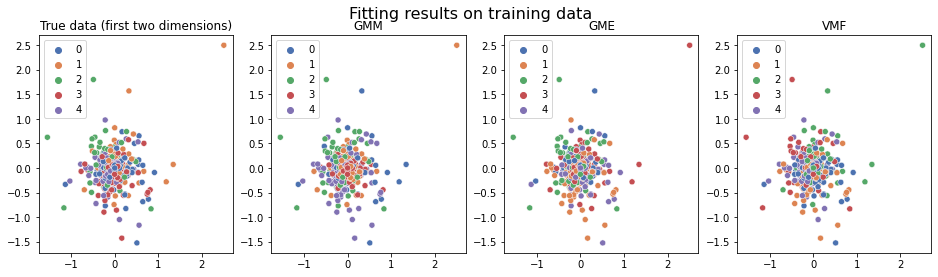

In [73]:
import matplotlib.pyplot as plt
import seaborn as sb

fig1 = plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=U[0], palette="deep")
plt.title('True data (first two dimensions)')
plt.subplot(1, 4, 2)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=pt.argmax(Uhat1_train, dim=1)[0], palette="deep")
plt.title('GMM')
plt.subplot(1, 4, 3)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=pt.argmax(Uhat2_train, dim=1)[0], palette="deep")
plt.title('GME')
plt.subplot(1, 4, 4)
sb.scatterplot(x=Y_train[0, 0, :], y=Y_train[0, 1, :], hue=pt.argmax(Uhat3_train, dim=1)[0], palette="deep")
plt.title('VMF')
fig1.suptitle('Fitting results on training data', fontsize=16)

Text(0.5, 0.98, 'Fitting results on test data')

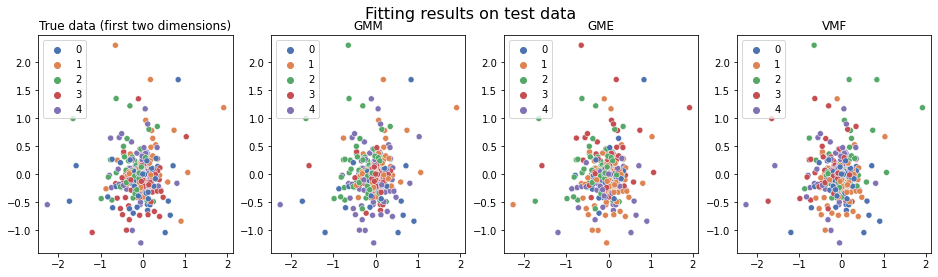

In [74]:
fig2 = plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=U[0], palette="deep")
plt.title('True data (first two dimensions)')
plt.subplot(1, 4, 2)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=pt.argmax(Uhat1_test, dim=1)[0], palette="deep")
plt.title('GMM')
plt.subplot(1, 4, 3)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=pt.argmax(Uhat2_test, dim=1)[0], palette="deep")
plt.title('GME')
plt.subplot(1, 4, 4)
sb.scatterplot(x=Y_test[0, 0, :], y=Y_test[0, 1, :], hue=pt.argmax(Uhat3_test, dim=1)[0], palette="deep")
plt.title('VMF')
fig2.suptitle('Fitting results on test data', fontsize=16)

### Testing prediction error, cosine error, and adjusted SSE on test data

In [75]:
# Step 3a. evaluate the fitted emission (actually the full model with
# freezing the arrangement model) models by a given criterion.
criterion = ['u_prederr', 'coserr', 'adjustSSE']
res_vmf = pt.empty(len(criterion), 3)
for c in range(len(criterion)):
    acc1 = evaluate_completion_emission(M1, Y_test, U_true=U, crit=criterion[c])
    acc2 = evaluate_completion_emission(M2, Y_test, U_true=U, crit=criterion[c])
    acc3 = evaluate_completion_emission(M3, Y_test, U_true=U, U_predict=Uhat3_test, crit=criterion[c])
    res_vmf[c, 0] = acc1
    res_vmf[c, 1] = acc2
    res_vmf[c, 2] = acc3
    print(acc1, acc2, acc3)

tensor(0.5050) tensor(0.3612) tensor(0.1584)
tensor(0.7331) tensor(0.6038) tensor(0.5536)
tensor(1.8425) tensor(2.2415) tensor(1.1153)


## Summarize as a comparable table

In [78]:
import pandas as pd
from IPython.display import display_html
from itertools import chain,cycle

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    
append_str = 'k = '
df1 = pd.DataFrame(data=res_gmm, index=["u_prederr", "coserr", "adjustSSE"], columns=["GMM", "GME", "VMF"])
df2 = pd.DataFrame(data=res_gme, index=["u_prederr", "coserr", "adjustSSE"], columns=["GMM", "GME", "VMF"])
df3 = pd.DataFrame(data=res_vmf, index=["u_prederr", "coserr", "adjustSSE"], columns=["GMM", "GME", "VMF"])

df1.style.highlight_max(color='lightgreen', axis=0)
df2.style.highlight_max(color='lightgreen', axis=0)
df3.style.highlight_max(color='lightgreen', axis=0)

display_side_by_side(df1,df2,df3, titles=['GMM','GME', 'VMF']) 

,GMM,GME,VMF
u_prederr,0.046200,0.052000,0.048200
coserr,0.429636,0.428898,0.429530
adjustSSE,39.466949,51.298100,6.396183
,GMM,GME,VMF
u_prederr,0.690400,0.704800,0.651800
coserr,0.686566,0.869532,0.684186
adjustSSE,38.085140,41.193542,8.688535
,GMM,GME,VMF
u_prederr,0.505000,0.36120,0.158400
coserr,0.733109,0.60379,0.553640
